# Co je v Notebooku

Hypotézy:

1. Půjde najít šachovnici co nemá obdélníkový tvar (kvůli průzoru) ✅
2. Půjde zkalibrovat kameru ✅
    1. tady je omezená stabilita zejména v distortion parametrech, je potřeba ohlídat přesnost zadaných bodů

## OpticalFlow - totálně selhalo

Body jde najít a trackovat. Problém je v absenci kvalitních bodů v prohlubních.

Z toho důvodu nelze spočítat, zda se posun na vršku vlákna a v prohlubni liší (z čehož by se počítala vzdálenost od kamery.

Testovány OpenCV algoritmy: 

- Lucas Canade
    - s automaticky vybranými body
        - relativně funguje, lze si kreslit trajektorii po obraze
    - s ručně zadanými body do prostředka obrazu
        - funguje špatně, v různých částech obrazu funguje různě kvalitně, takže nahoře a dole se chytá i špatných bodů
        - byl by potřeba nějaký zásadní ořez snímků
- Dense Optical Flow - Farneback
    - nefunguje vůbec
    - vektory pohybu převedu na úhly a magnitudy
        - úhly ty směřují do všech stran, je to spíše podle pozice v obraze, nebo posunu stínů
        - magnitudy jsou potom veskrze náhodné

Essential matrix

- referenční body pomocí SIFT + Flann
    - funguje dobře, opět problém s tím, že body jsou na vršku vláken nikoli v prohlubních. Z tohoto pohledu se jeví nejvhodnější body zadat ručně a ručně je trackovat
- Použití essential matrix pro odhad rotace framů
    - méně stabilní než detekce směru hran
    - rotace kumulativně nevychází (navíc jsou tam 2 řešení) a lokálně jsou v ní záškuby, obecně špatné výsledky
- Analyzován posun kamery (to je docela zajímavé)
    
    ![Screenshot 2024-12-04 at 16.49.28.png](https://prod-files-secure.s3.us-west-2.amazonaws.com/0b94ba7b-0635-4a2f-ac04-5cc5151e5725/ec345021-0910-4e4f-8181-e6259ff5e159/Screenshot_2024-12-04_at_16.49.28.png)
    

Ten pattern nevypadá špatně, ale nějak pro něj nemám vysvětlení. Kamera je fakticky na místě. Ale je pravdou, že kouká na obraz závitů, které se rotací jakoby posouvají??

## Sestavení MIO pro jeden řádek

Pro jeden řádek obrazu připravený tak, aby vlákno s ním šlo paralelně, jsem se pokusil sestavit MIO - tj. zregistrovat všechny pixely v rámci celé 360° rotace.

Na MIO je vidět, že obraz se posouvá v různých částech obrazu různě rychle (? chybná rektifikace?) tj. pokud trackuji světlý bod jsou jeho obrazy nejprve šikmo vlevo, potom se vrací na střed a nakonec jsou šikmo vpravo

Levá část obrazu (šmouhy směřují doleva)

![Screenshot 2024-12-04 at 16.54.18.png](https://prod-files-secure.s3.us-west-2.amazonaws.com/0b94ba7b-0635-4a2f-ac04-5cc5151e5725/238baddc-9161-47e9-acd7-102eb82dd6bb/Screenshot_2024-12-04_at_16.54.18.png)

Pravá část obrazu (šmouhy směřují doprava)

![Screenshot 2024-12-04 at 16.55.22.png](https://prod-files-secure.s3.us-west-2.amazonaws.com/0b94ba7b-0635-4a2f-ac04-5cc5151e5725/483ff15c-bfe1-4eae-9084-a374db389e01/Screenshot_2024-12-04_at_16.55.22.png)

Sestavení je udělané pomocí “konstantní rychlosti”. Tj. lepení pro začátek 360° otočky je “pomalé” a pro konec “rychlé”. 

Hypotéza: Kamera není ve středu obrazu a ten se skutečně pohybuje variabilní rychlostí.

## Co vyzkoušet dál?

Je naprosto zásadní dostat video, kde je:

- čtvercový výřez
- jenom závit
- závit je orientován z leva do prava
- v rámci optical flow sledujeme pouze x-shift

Totéž asi bude platit i pro neuronku, tj. zaměřit se na kompenzaci úhlu. Posunu středu rotace, atd.

Střed rotace se posouvá podle zaostření kamery (tj. jeho detekce by měla být součástí kalibrace)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from steps.checkerboard_corners import process_image
from tqdm.notebook import tqdm
import traceback

In [239]:
ROOT = "/Users/gimli/cvr/data/zavity/trojan/03122024_sachovnice"
#ROOT = "/Users/gimli/cvr/data/zavity/trojan/checkerboard-with-video"
#ROOT = "/Users/gimli/cvr/data/zavity/trojan/02122024_sachovnice"
assert os.path.isdir(ROOT)

In [240]:
#cap = cv2.VideoCapture(os.path.join(ROOT, "GX010015.MP4")
#cap = cv2.VideoCapture(os.path.join(ROOT, "RED_sachovnice.MP4"))
cap = cv2.VideoCapture(os.path.join(ROOT, "_checkerboard_all.mp4"))

In [241]:
fps = cap.get(cv2.CAP_PROP_FPS)
frames_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
# 02122024 for checkerboard-with-video use all frames
#checkerboard_intervals = np.array([[4, 6], [14, 29], [38, 50]]) * 25
frame_nos = np.arange(0, frames_count, 200)
#frame_nos = np.concatenate([(np.arange(interval[0], interval[1])) for interval in checkerboard_intervals])
# frame_nos = np.arange(frames_count)

In [242]:
valids = []
for frame_no in tqdm(frame_nos):
    try:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
        success, frame = cap.read()
        if success:        
            # TODO: write somewhere the parameter here
            objpoints, imgpoints = process_image(frame, 6) 
            if objpoints.size >= 10 * 3:
                valids.append((frame_no, frame, objpoints, imgpoints))
                print(f"Frame {frame_no}: {len(objpoints)}")
            # else:
            #     print(f"xFrame {frame_no}: {len(objpoints)}")
    except Exception as e:
        print(f"General exception at {frame_no}: {e}")
        print(traceback.format_exc())

  0%|          | 0/50 [00:00<?, ?it/s]

Frame 0.0: 54
Frame 200.0: 50
Frame 600.0: 22
Frame 1200.0: 51
Frame 1600.0: 45
Frame 2600.0: 71
Frame 3200.0: 44
Frame 3600.0: 54
Frame 4000.0: 17
Frame 4200.0: 40
Frame 4400.0: 25
Frame 5000.0: 19
Frame 5200.0: 24
Frame 5400.0: 16
Frame 6000.0: 31
Frame 6400.0: 53
Frame 7000.0: 18
Frame 7400.0: 41
Frame 8200.0: 34
Frame 8600.0: 13
Frame 8800.0: 25
Frame 9200.0: 43
Frame 9800.0: 46


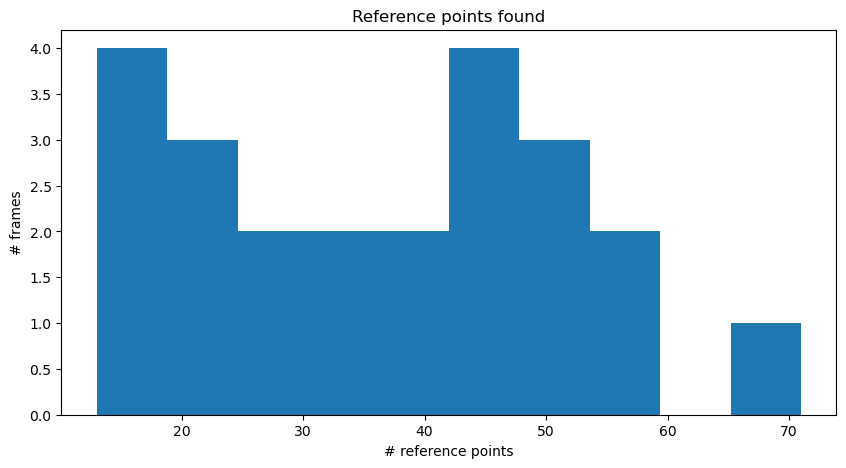

In [243]:
plt.figure(figsize=(10,5))
plt.hist([len(objpoints) for frame_no, frame, objpoints, imgpoints in valids])
plt.title("Reference points found")
plt.xlabel("# reference points")
plt.ylabel("# frames")
plt.show()

In [244]:
# Dump images into folder for manual check
TMP = os.path.join(ROOT, "checkerboard-corners")
os.makedirs(TMP, exist_ok=True)
revalids = []
for frameno, frame, objpoints, imgpoints in valids:
    plt.figure(figsize=(20,11))
    plt.imshow(frame)
    plt.scatter(imgpoints[:,0], imgpoints[:, 1], color="red", marker="o", facecolors='none')
    recomputed = cv2.cornerSubPix(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), 
                                  imgpoints.astype(np.float32), 
                                  (15,15), 
                                  (-1,-1), 
                                  (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001))
    plt.scatter(recomputed[:,0], recomputed[:, 1], color="blue", marker="o", facecolors='none')
    plt.tight_layout()
    plt.savefig(os.path.join(TMP, f"{frameno.astype(int):03d}.png"))
    plt.close()
    revalids.append((frameno, frame, objpoints, recomputed))

## Calibrate camera

In [245]:
w, h = frame.shape[:2][::-1]

In [246]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    [objpoints.astype(np.float32) for _, _, objpoints, _ in revalids], 
    [imgpoints.astype(np.float32) for _, _, _, imgpoints in revalids], 
    (w,h), 
    None, 
    None
)

In [258]:
mtx = np.array([[18232.854794551517, 0.0, 1708.4055496682372], [0.0, 17944.21311070364, 890.002470566316], [0.0, 0.0, 1.0]])
dist = np.array([[-1.6301575669808466, -180.26430132808852, 0.010055069152415585, 0.031137678361720926, -0.11775296863311922]])

In [248]:
import json
## If you want previously loaded data
cam_calib = json.load(open(os.path.join(ROOT, "checkerboard-calibration.json"), "rt"))
mtx = np.array(cam_calib["mtx"])
dist = np.array(cam_calib["dist"])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/gimli/cvr/data/zavity/trojan/03122024_sachovnice/checkerboard-calibration.json'

In [259]:
w = 3840
h = 2160
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)

In [16]:
# If you want dump camera calibration data
# import json
# 
# class NumpyEncoder(json.JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         return super().default(obj)
# 
# json.dump({
#     "ret": ret,
#     "mtx": mtx,
#     "newcameramtx": newcameramtx,
#     "dist": dist,
#     "rvecs": rvecs,
#     "tvecs": tvecs
# }, open(os.path.join(ROOT, "checkerboard-calibration.json"), "wt"), cls=NumpyEncoder)

In [260]:
dst = cv2.remap(frame, mapx, mapy, cv2.INTER_LINEAR)

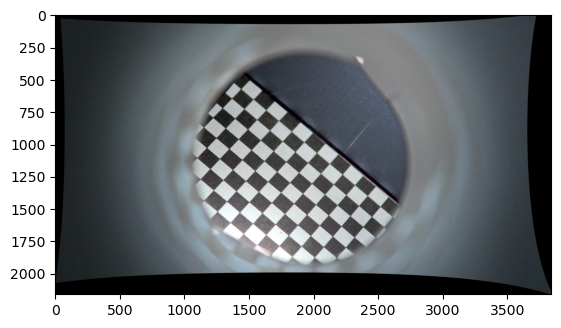

In [261]:
plt.imshow(dst)
plt.show()

In [36]:
newcameramtx

array([[1.61684702e+04, 0.00000000e+00, 1.65497371e+03],
       [0.00000000e+00, 1.57736039e+04, 8.65542796e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

# Rectify video
Take the video file and apply the calibration.

In [39]:
video_file = os.path.join(ROOT, "WHITE_Sachovnici_a_ZH.MP4")
vidcap = cv2.VideoCapture(video_file)

out = cv2.VideoWriter(os.path.join(ROOT, 'WHITE_Sachovnici_a_ZH-undistorted.mp4'), 
                      apiPreference=cv2.CAP_FFMPEG,
                      fourcc=cv2.VideoWriter_fourcc(*"H264"),
                      fps=25.0,
                      # It is crucial to properly setup header of the writer otherwise the file will be empty
                      frameSize=(w, h),  # doublecheck that the frames has same size as is written here
                        params=[
                            cv2.VIDEOWRITER_PROP_DEPTH,
                            cv2.CV_8U,  # Format must match out.write data
                            cv2.VIDEOWRITER_PROP_IS_COLOR, # If you write RGB images this must be 1 (grayscale = 0) 
                            1,  # True
                        ])

frame_count = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
for frame_no in tqdm(np.arange(frame_count)):
    success, frame = vidcap.read()
    if not success:
        break
    
    undistorted = cv2.remap(frame, mapx, mapy, cv2.INTER_LINEAR)    
    out.write(undistorted.astype(np.uint8)) # doublecheck that the frames has same size as is written in the header
 
out.release()

OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


  0%|          | 0/33592 [00:00<?, ?it/s]

## Optical flow

otestovány obě varianty opencv trackování featur bez úspěchu
1) Lucas Kanade víceméně trackuje featury, které se byverou (goodFeaturesToTrack) ale postrádá schopnost trackovat všechny body (natožpak odchylky od "průměrného" posunu
2) Farneback - úhly ukazují do všech směrů a tudíž magnituda je nepoužitelná, zde by to chtělo nějaký constraint, že se všechny body pohybují stejným směrem

### Tracking of SIFTs
SIFTs seems to be very robust for estimation of the transformation and computation of essential matrix. For the point matching FLANN algorithm is used.

From these we can make the registration more precise.

But from the point of view of the 

In [12]:
import subprocess
import tempfile
import imageio.v3 as iio
import cv2
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import numpy as np
from matplotlib.patches import Circle

### Rotace videa pro stejnou orientaci

In [13]:
cap = cv2.VideoCapture(os.path.join(ROOT, "737_GX010021-undistorted.MP4"))
rectified = []
while(1):
    success, frame = cap.read()
    if not success:
        break
    rectified.append(frame)
    if len(rectified) == 1000:
        break

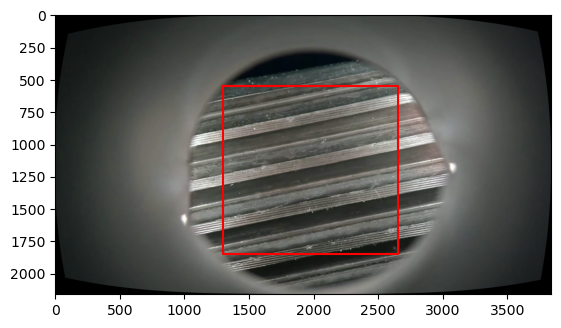

In [14]:
x1, x2 = 1300, 2650
y1, y2 = 550, 1850
plt.imshow(rectified[0])
plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color="red")
plt.show()

In [131]:
def compute_frame_angles(frame, crop=None):
    if crop is not None:
        x1, x2, y1, y2 = crop
        undistorted =  frame[y1:y2, x1:x2, 0]
    else:
        undistorted = frame[:, :, 0]
        
    otsu_threshold, _ = cv2.threshold(undistorted, 0, 255, cv2.THRESH_OTSU)
    
    with tempfile.NamedTemporaryFile(suffix=".pgm", delete=False) as tmpfile:
        filename = tmpfile.name
        iio.imwrite(tmpfile.name, undistorted)  # this must be a grayscale image
        process = subprocess.Popen(
            ["/Users/gimli/projects/scripts/devernay", tmpfile.name,
             "-t", "/dev/stdout",
             "-l", f"{otsu_threshold / 15}",
             "-h", f"{otsu_threshold / 3}",
             "-p", "/Users/gimli/sample.pdf",
             "-s", f"1",
             ], stdout=subprocess.PIPE)
        tmpfile.close()
    result = process.stdout.read().decode("utf-8")
    lines = result.split("\n")
    dev = []
    for line in lines:
        if line != "":
            x, y = line.split(' ')
            dev.append((float(x), float(y)))
    dev = np.array(dev)
    if len(dev) == 0:
        print("Something wrong happen")
    samples = 1000
    choice = np.random.randint(0, len(dev), samples)
    xx0 = np.matmul(dev[choice, 0].reshape(-1, 1), np.ones((1, len(choice))))
    yy0 = np.matmul(dev[choice, 1].reshape(-1, 1), np.ones((1, len(choice))))
    xx1 = np.matmul(np.ones((len(choice), 1)), dev[choice, 0].reshape(1, -1))
    yy1 = np.matmul(np.ones((len(choice), 1)), dev[choice, 1].reshape(1, -1))
    valid = np.zeros_like(xx0, dtype=bool)
    valid[xx0 != xx1] = 1
    angles = np.zeros_like(xx0, np.float32)
    angles[xx0 == xx1] = np.pi / 2
    angles[valid] = np.arctan((yy0[valid] - yy1[valid]) / (xx0[valid] - xx1[valid])).reshape(-1)
    angles[np.eye(samples, dtype=bool)] = np.nan
    
    filtered = np.rad2deg(np.abs(angles[~np.isnan(angles)]))
    
    if filename is not None and os.path.exists(filename):
        os.remove(filename)
    
    counts, values = np.histogram(filtered, bins=samples)
    
    return values[np.argmax(counts)], filtered

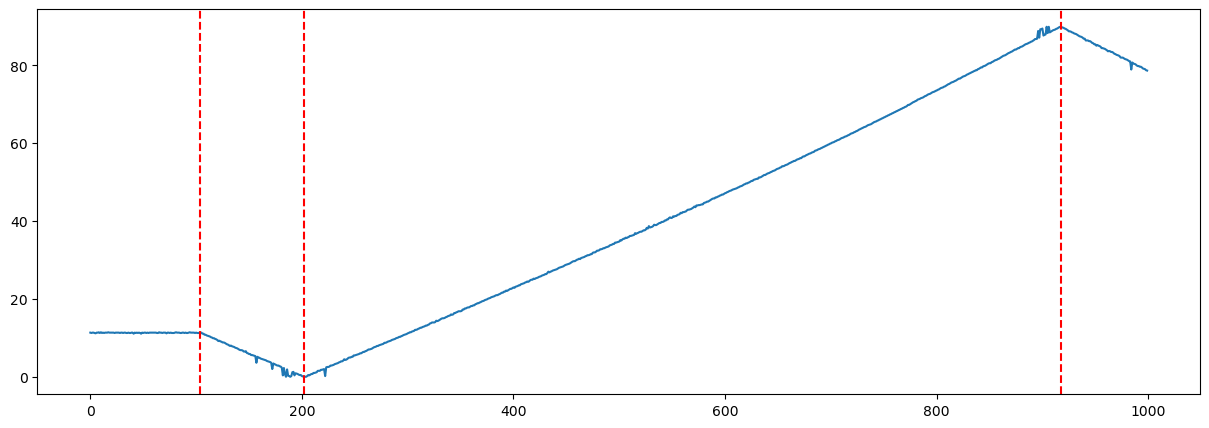

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(frame_angles)
plt.axvline(104, color="red", linestyle="--")
plt.axvline(202, color="red", linestyle="--")
plt.axvline(918, color="red", linestyle="--")
plt.show()

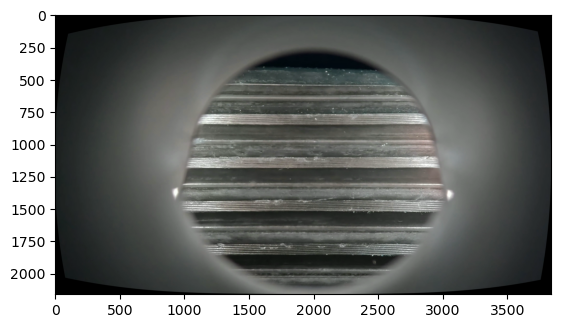

In [32]:
plt.imshow(rectified[202])
plt.show()

Aproximace všech rotací není lineární. Testováno na polyfitu se stupněm 1. Odchylka je asi ±2°.
Pohledově OK je aproximace stupněm 5.
Níže je aplikace této aproximace (abychom eliminovali šum).

In [17]:
frame_angles = np.array(frame_angles)
fa = np.concatenate([frame_angles[104:202], -frame_angles[202:918], -180 + frame_angles[918: ]])
poly = np.polyfit(np.arange(len(fa)), fa, 5)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


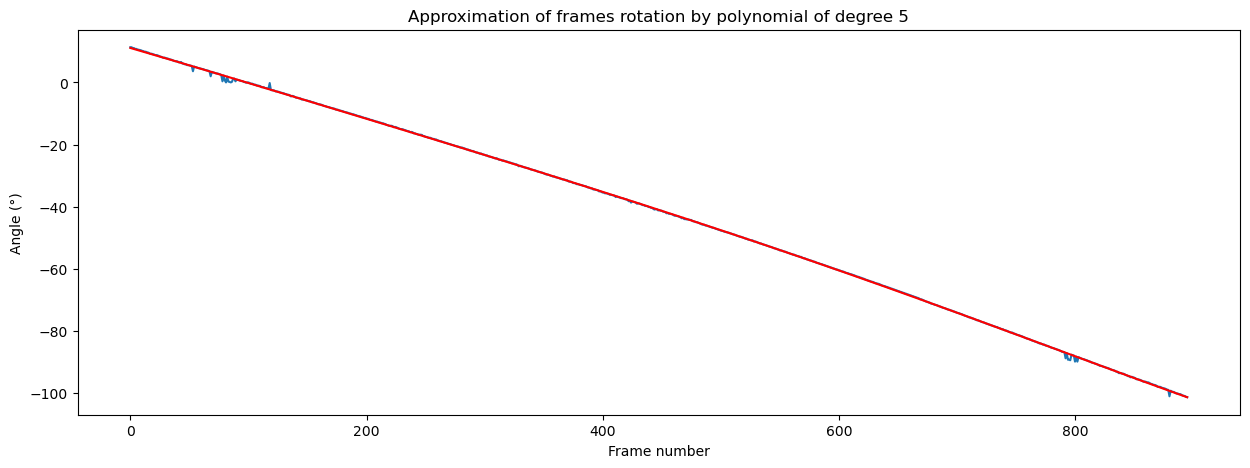

In [903]:
plt.figure(figsize=(15,5))
plt.plot(fa)
plt.plot(np.polyval(poly, np.arange(len(fa))), color="red")
plt.title("Approximation of frames rotation by polynomial of degree 5")
plt.xlabel("Frame number")
plt.ylabel("Angle (°)")
plt.show()

In [33]:
# Orotování vybraných framů
rotated = []
for frame, err_angle in tqdm(zip(rectified[104:], np.polyval(poly, np.arange(len(fa)))), total=len(rectified[104:])):  
    rot = cv2.getRotationMatrix2D((1920, 1080), -err_angle, 1)
    rotated.append(cv2.warpAffine(frame, rot, (3840, 2160)))

  0%|          | 0/896 [00:00<?, ?it/s]

### Střed rotace není ve středu framu

Potřebujeme při ořezu nějaký kompromis (vizualizace níže dává nějakou představu, jak by ořez mohl být nastaven univerzálně)

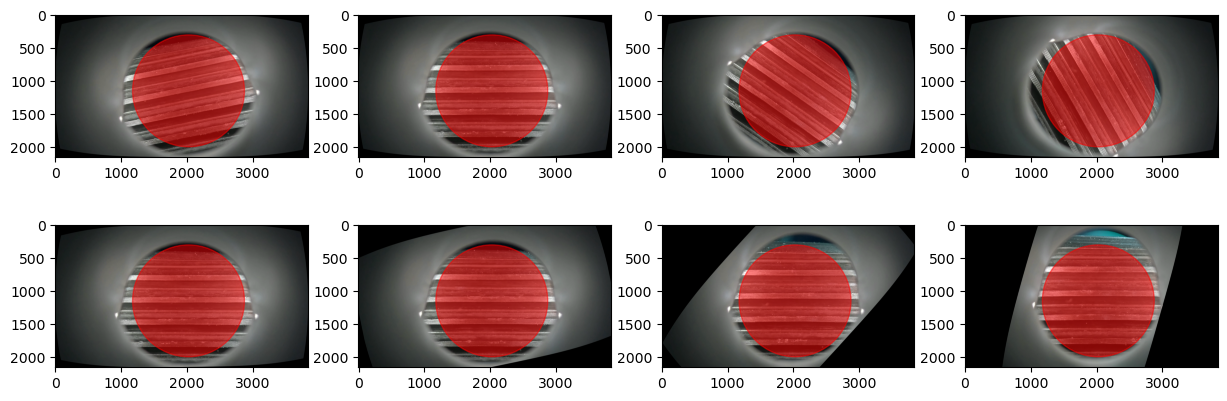

In [912]:
plt.figure(figsize=(15, 5))
to_draw = []
[to_draw.append(rectified[fno]) for fno in [104, 200, 500, 700]]
[to_draw.append(rotated[fno]) for fno in [104, 200, 500, 700]]    
for idx, frame in enumerate(to_draw):
    ax = plt.subplot(2, 4, idx+1)
    ax.imshow(frame)
    ax.add_patch(Circle((2025, 1150), radius=850, color='red', alpha=0.5))
plt.show()

In [495]:
def homogeneize(rgb):
    return cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)

positions = []
sift =cv2.SIFT_create()
for frame in tqdm(rectified[200:250]):    
    positions.append(sift.detectAndCompute(homogeneize(frame), None))

  0%|          | 0/50 [00:00<?, ?it/s]

In [496]:
# SIFT point matching ... this seems to be robust enough
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

point_pairs = []
for prv, nxt in tqdm(zip(positions[:-1], positions[1:]), total=len(positions)-1):
    matches = flann.knnMatch(prv[1], nxt[1], k=2)
    objpoints = []
    imgpoints = []
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.1*n.distance:
            objpoints.append(prv[0][m.queryIdx].pt)
            imgpoints.append(nxt[0][m.trainIdx].pt)
    point_pairs.append((objpoints, imgpoints))
    

  0%|          | 0/49 [00:00<?, ?it/s]

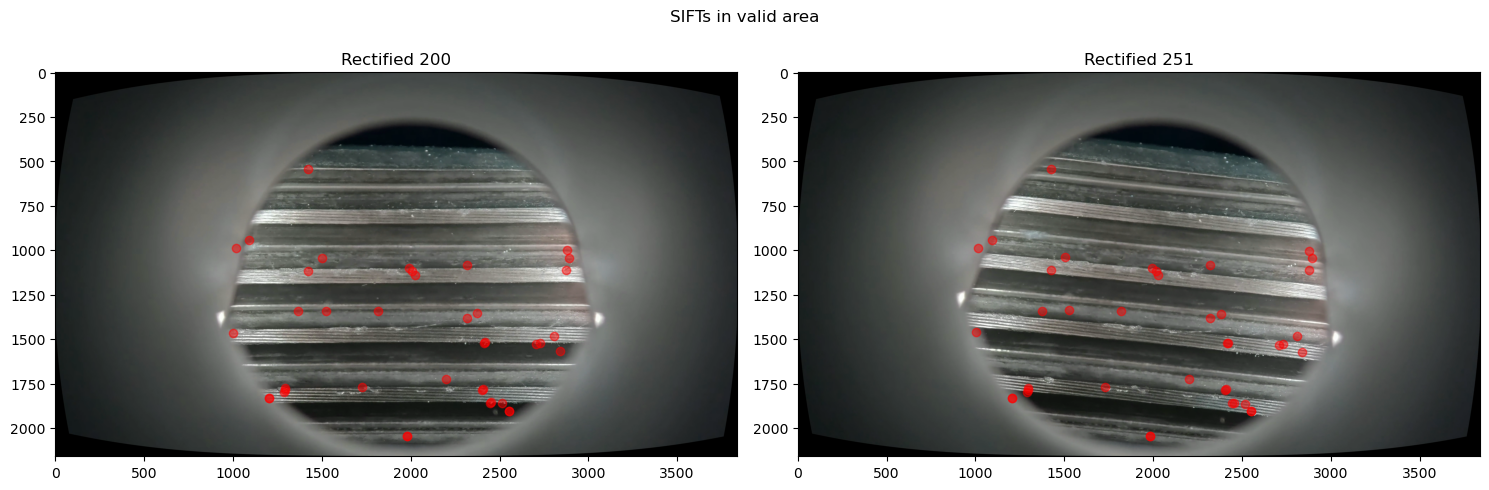

In [918]:
# Preview for visualization of found SIFTs
plt.figure(figsize=(15,5))
ax = plt.subplot(121)
ax.imshow(rectified[200])
objpoints = np.array(point_pairs[0][0])
imgpoints = np.array(point_pairs[0][1])
ax.scatter(objpoints[:,0], objpoints[:,1], color="red", alpha=0.5)
ax.set_title("Rectified 200")
ax = plt.subplot(122)
ax.imshow(rectified[251])
ax.scatter(imgpoints[:,0], imgpoints[:,1], color="red", alpha=0.5)
ax.set_title("Rectified 251")
plt.suptitle("SIFTs in valid area")
plt.tight_layout()
plt.show()

In [747]:
E, mask = cv2.findEssentialMat(objpoints, imgpoints, method=cv2.RANSAC, threshold=0.035)

In [919]:
def dehom(pts):
    """
    Conversion from homogeneous to cartesian coordinates.
    """
    return pts[:,:,:-1] / pts[:,:,-1]

def hom(pts):
    """
    Converts points into homogeneous coordinate system"
    @param pts: vector of 2D or points
    @return pts elongated by 1 for every point
    """
    return np.concatenate([pts, np.ones((pts.shape[0],1))], axis=1)

The function below tries to find out corresponding epipolar point for given input point. For this purpose epipolar line is found and then neighborhood along this line is extracted. The same is done reversely for the input point. Found "spectra" are returned.

Parameter for configuration works as follows:
- spectral_length says how many values along the epipolar line are taken
- expected shift says where the spectra from imgA should be placed in imgB
  - <span style="color:red">NOTE: problem here is that orientation of the epipolar line is not in sync with other lines, therefore the spectrum can be flipped :/</span>
- variability says how far from expected shift the spectrum will be compared (i.e. how far it is possible to find the correspondence)

In [869]:
from scipy.interpolate import RectBivariateSpline
# for objpoint from first image find candidates in the second image
def spectra(imgA, imgB, ptsA, E, spectral_length, expected_shift, variability): 
    """
    For set of points finds correspondence candidates in second image according to epipolar geometry
    @param imgA first image (intensities of the input are taken from this image)
    @param imgB second image (intensities of the correspondence candidates and their neigbors are take from this image)
    @param E is Essential matrix for imgA and imgB
    @param spectral_length - number of neighbors taken into account
    @param expected_shift - distance of the candidates from "no shift"
    @param variability - variability in the shift of various pixels across whole image
    @return 
        - pt_distance is distance between the [x, y] of input point in 2nd image and the epipolar line
        - candidates are points coordinates on shifted epipolar line (to the input point) backward and forward
        - neigA are points coordinates neigboring with the input point in imageA along the epipolar line
        - spectrA are intensities of points in neigA
        - spectrB are intensities of points in candidates
    """
    linesB = cv2.computeCorrespondEpilines(ptsA.reshape(-1,1,2), 1, E).reshape(-1,3)
    print(linesB[0])

    pt_distance = np.sum(linesB * hom(ptsA), axis=1)

    candidates = []
    assert expected_shift > 0  # TODO: vairant with unexpected shift
    for t in np.arange(-spectral_length - expected_shift - variability, expected_shift + variability + spectral_length):
        candidates.append(np.stack([ptsA[:,0] - linesB[:,1] * t, ptsA[:,1] + linesB[:,0] * t], axis=1))
    candidates = np.flip(np.moveaxis(np.array(candidates), 0, 1), axis=1)
    spline = RectBivariateSpline(np.arange(imgB.shape[0]), np.arange(imgB.shape[1]), imgB)
    spectrB = spline(candidates[:,:,0], candidates[:,:,1], grid=False)

    # take the epiline in the source image and copy few pixels along the line from the source image
    linesA = cv2.computeCorrespondEpilines(candidates[:, expected_shift + variability + spectral_length, :], 2, E).reshape(-1,3)
    print(linesA[0])
    neigA = []
    for t in np.arange(-spectral_length, spectral_length):
        neigA.append(np.stack([ptsA[:,0] - linesA[:,1] * t, ptsA[:,1] + linesA[:,0] * t], axis=1))
    neigA = np.moveaxis(np.array(neigA), 0, 1)
    spline = RectBivariateSpline(np.arange(imgA.shape[0]), np.arange(imgA.shape[1]), imgA)
    spectrA = spline(neigA[:,:,0], neigA[:,:,1], grid=False)

    return pt_distance, candidates, neigA, spectrA, spectrB

In [883]:
spectral_length = 20
expected_shift = 4
variability = 4
dist, cands, neigA, spectrA, spectrB = spectra(homogeneize(rectified[200]), homogeneize(rectified[201]), objpoints, E, spectral_length, expected_shift, variability)

[-9.87377168e-01 -1.58386638e-01  1.22187986e+03]
[ 9.87532638e-01  1.57414384e-01 -1.22047790e+03]


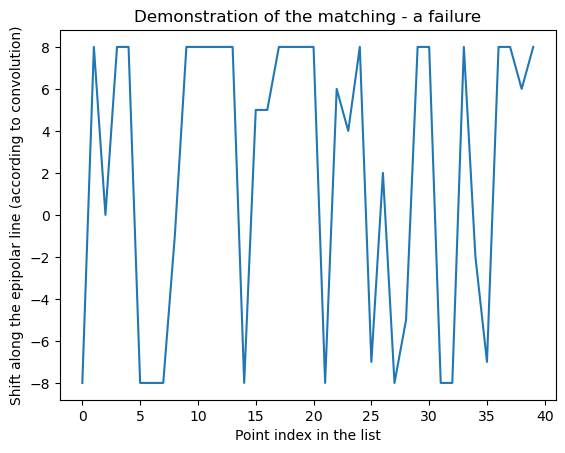

In [921]:
shifts = []
plt.figure()
for pt in np.arange(cands.shape[0]):
    shifts.append(np.argmax(
        np.convolve(spectrB[pt], spectrA[pt], mode="same")[spectral_length : spectral_length + 2 * expected_shift + 2 * variability + 1]
    ) - expected_shift - variability)
plt.plot(shifts)
plt.title("Demonstration of the matching - a failure")
plt.xlabel("Point index in the list")
plt.ylabel("Shift along the epipolar line (according to convolution)")
plt.show()
# There is a lot of edge values, which are definitely not correct

## Rotation by Essential matrix

Na hlubší analýzu ... něco vychází, grafy vypadají věrohodně, ale aplikace na video pokulhává.

In [52]:
thread_start_fno = (7 * 60 + 5) * fps
round = 48 * fps

In [53]:
cap.get(cv2.CAP_PROP_FRAME_COUNT)

33592.0

In [54]:
thread_start_fno

25474.525474525475

In [78]:
def rotation_matrix_to_angle(R):
    # Compute the trace of the rotation matrix
    trace = np.trace(R)
    
    # Calculate the angle
    theta = np.arccos(np.clip((trace - 1) / 2.0, -1.0, 1.0))
    
    return np.rad2deg(theta)

In [99]:
cap.set(cv2.CAP_PROP_POS_FRAMES, int(thread_start_fno))
sift =cv2.SIFT_create()

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params, search_params)

success, prv = cap.read()
prv_sift = sift.detectAndCompute(cv2.cvtColor(prv, cv2.COLOR_BGR2GRAY), None)
essentials = []
for i in tqdm(np.arange(round)):
    success, frame = cap.read()
    if not success:
        break    
        
    frame_sift = sift.detectAndCompute(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), None)
    matches = flann.knnMatch(prv_sift[1], frame_sift[1], k=2)
    
    objpoints = []
    imgpoints = []
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.1*n.distance:
            objpoints.append(prv_sift[0][m.queryIdx].pt)
            imgpoints.append(frame_sift[0][m.trainIdx].pt)
    E, mask = cv2.findEssentialMat(
        np.array(objpoints).reshape(-1, 1, 2), 
        np.array(imgpoints).reshape(-1, 1, 2), 
        cameraMatrix1=newcameramtx, 
        distCoeffs1=dist, 
        cameraMatrix2=newcameramtx, 
        distCoeffs2=dist, 
        method=cv2.RANSAC, 
        threshold=0.035
    )
    # if E is None:
    #     print(f"Essential matrix computation failed {}")
    R1, R2, t = cv2.decomposeEssentialMat(E)
    a1, a2 = rotation_matrix_to_angle(R1), rotation_matrix_to_angle(R2)
    essentials.append((i, (a1, a2, t) if a2 > 90 else (a2, a1, t)))
    prv_sift = frame_sift
    prv = frame
    

  0%|          | 0/2878 [00:00<?, ?it/s]

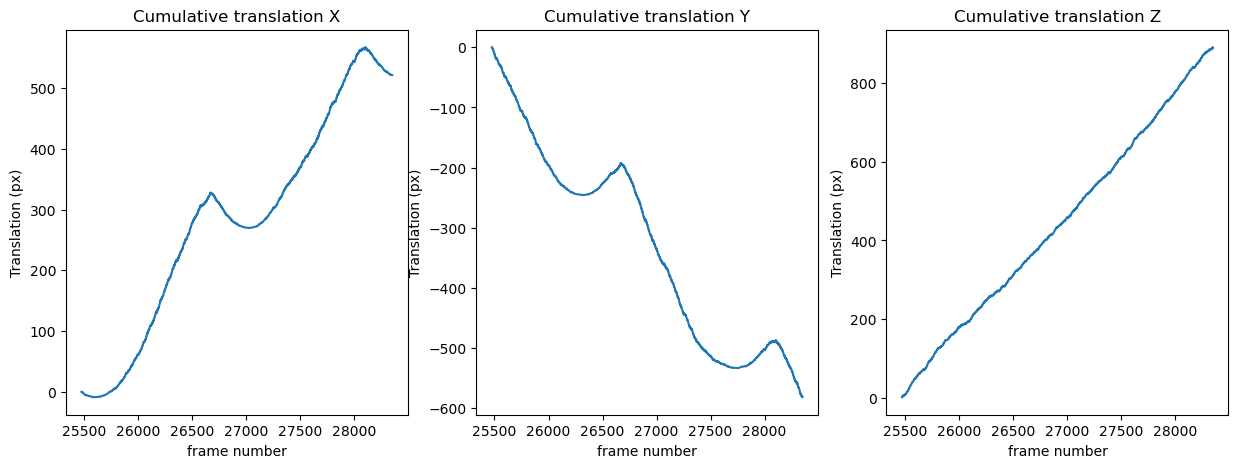

In [108]:
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
ax.plot(np.arange(thread_start_fno, thread_start_fno + len(essentials)), np.cumsum([e[1][2][0] for e in essentials]))
ax.set_title("Cumulative translation X")
ax.set_xlabel(f"frame number")
ax.set_ylabel("Translation (px)")
ax = plt.subplot(132)
ax.plot(np.arange(thread_start_fno, thread_start_fno + len(essentials)), np.cumsum([e[1][2][1] for e in essentials]))
ax.set_title("Cumulative translation Y")
ax.set_xlabel(f"frame number")
ax.set_ylabel("Translation (px)")
ax = plt.subplot(133)
ax.plot(np.arange(thread_start_fno, thread_start_fno + len(essentials)), np.cumsum([e[1][2][2] for e in essentials]))
ax.set_title("Cumulative translation Z")
ax.set_xlabel(f"frame number")
ax.set_ylabel("Translation (px)")
plt.show()

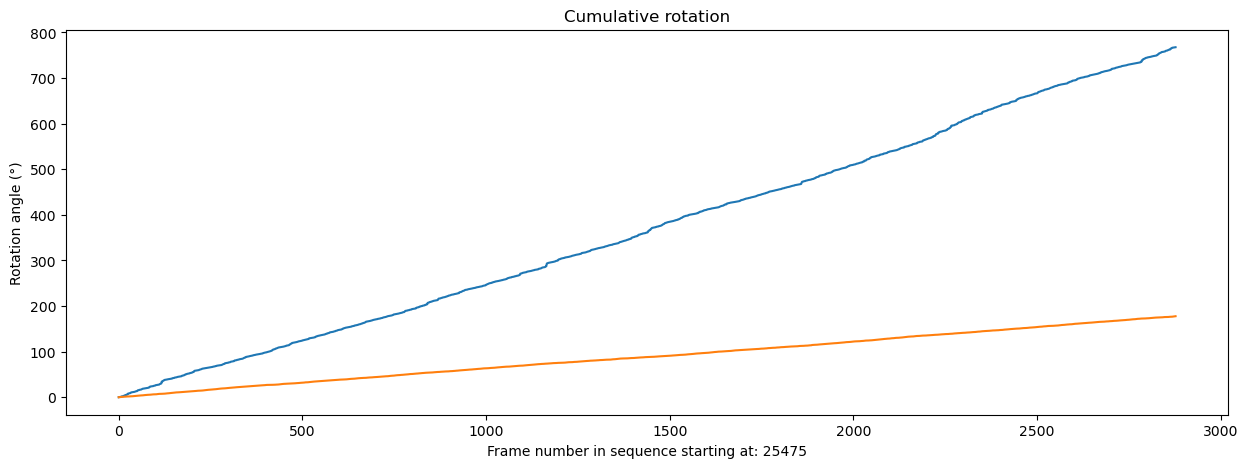

In [128]:
plt.figure(figsize=(15,5))
plt.plot(np.cumsum([e[1][0] for e in essentials]))
plt.plot(np.cumsum([180 - e[1][1] for e in essentials]))
plt.title("Cumulative rotation")
plt.xlabel(f"Frame number in sequence starting at: {thread_start_fno:.0f}")
plt.ylabel("Rotation angle (°)")
plt.show()

### Generate rotation compensated video

In [137]:
import tempfile
import subprocess

In [139]:
cap.set(cv2.CAP_PROP_POS_FRAMES, int(thread_start_fno))

frame_angles = []
hists = []
for i in tqdm(np.arange(round)):
    success, frame = cap.read()
    frame_angle, hist = compute_frame_angles(frame, [1300, 2650, 550, 1850])
    frame_angles.append(frame_angle)
    hists.append(hist)

  0%|          | 0/2878 [00:00<?, ?it/s]

In [232]:
def fix_monotonicity(frame_angles):
    fa = np.copy(frame_angles)
    direction = []
    for i in np.arange(10, len(fa) - 10):
        direction.append(np.sign(np.median(-fa[i-10 : i]) + np.median(fa[i : i+10])))
    break_points = np.where(np.abs(np.diff(direction)) > 0)[0]

    sequence_cuts = zip([0] + break_points.tolist(), break_points.tolist() + [len(frame_angles)])
    seq_end = None
    for low_cut, high_cut in sequence_cuts:
        if seq_end is None:
            if 90 - fa[high_cut-1] < fa[high_cut-1]:
                fa[low_cut:high_cut] = 90 - fa[low_cut:high_cut]                
        else:        
            if direction[(high_cut + low_cut) // 2] == 1:
                fa[low_cut:high_cut] = np.round((seq_end + fa[low_cut]) / 90) * 90 - fa[low_cut:high_cut] 
            else:
                fa[low_cut:high_cut] = np.round((seq_end - fa[low_cut]) / 90) * 90 + fa[low_cut:high_cut]                                
            
        seq_end = fa[high_cut-1]
    return fa
        

In [234]:
frame_angles = np.array(frame_angles)
fa = fix_monotonicity(frame_angles)
poly = np.polyfit(np.arange(len(fa)), fa, 5)

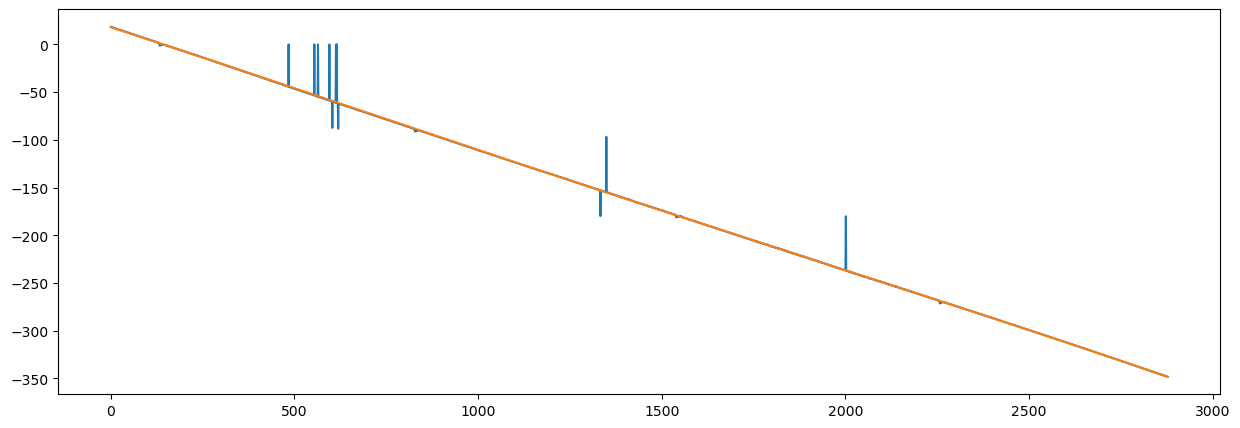

In [236]:
plt.figure(figsize=(15,5))
plt.plot(fa)
plt.plot(np.polyval(poly, np.arange(len(fa))))
plt.show()

In [238]:
# Orotování vybraných framů
cap.set(cv2.CAP_PROP_POS_FRAMES, int(thread_start_fno))

out = cv2.VideoWriter(os.path.join(ROOT, 'compensated.mp4'), 
                      apiPreference=cv2.CAP_FFMPEG,
                      fourcc=cv2.VideoWriter_fourcc(*"H264"),
                      fps=fps,
                      frameSize=(frame.shape[1], frame.shape[0]),
                        params=[
                            cv2.VIDEOWRITER_PROP_DEPTH,
                            cv2.CV_8U,
                            cv2.VIDEOWRITER_PROP_IS_COLOR,
                            1,  # false
                        ])

for err_angle in tqdm(np.polyval(poly, np.arange(len(fa)))):
    success, frame = cap.read()
    if not success:
        break
    rot = cv2.getRotationMatrix2D((frame.shape[1] // 2, frame.shape[0] // 2), -err_angle, 1)
    rotated = cv2.warpAffine(frame, rot, (frame.shape[1], frame.shape[0]))  
    out.write(rotated.astype(np.uint8))
    
out.release()

OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


  0%|          | 0/2878 [00:00<?, ?it/s]

# OIO and MIO analysis

In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import imageio.v3 as iio

In [20]:
speeds = np.load("/Users/gimli/cvr/data/zavity/trojan/checkerboard-with-video/oio/737_GX010021-undistorted_preprocessed-speeds.npy",
                 allow_pickle=True)

In [21]:
cap = cv2.VideoCapture("/Users/gimli/cvr/data/zavity/trojan/checkerboard-with-video/oio/737_GX010021-undistorted_preprocessed.mp4")

In [22]:
cap.set(cv2.CAP_PROP_POS_FRAMES, 25)
frames = []
for i in np.arange(100):
    success, frame = cap.read()
    frames.append(frame)

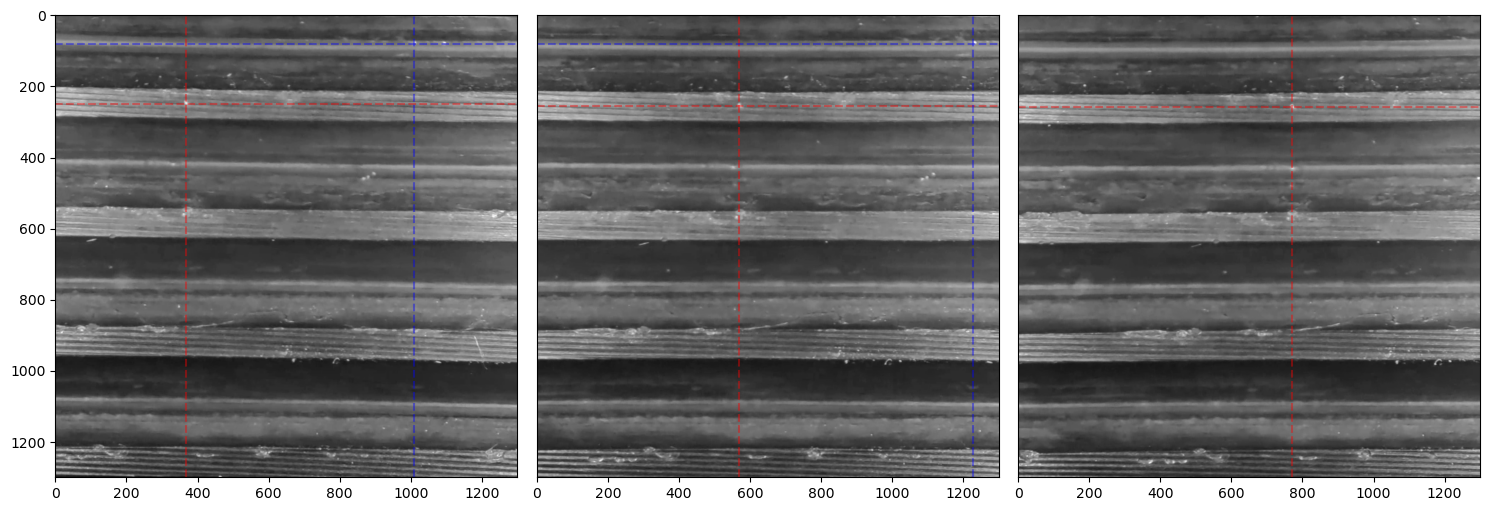

In [23]:
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
ax.axvline(368, color="red", linestyle="--", alpha=0.4)
ax.axhline(248, color="red", linestyle="--", alpha=0.4)
ax.axvline(1010, color="blue", linestyle="--", alpha=0.4)
ax.axhline(80, color="blue", linestyle="--", alpha=0.4)
ax.imshow(frames[0])
ax = plt.subplot(132)
ax.imshow(frames[50])
ax.axvline(569, color="red", linestyle="--", alpha=0.4)
ax.axhline(256, color="red", linestyle="--", alpha=0.4)
ax.axvline(1227, color="blue", linestyle="--", alpha=0.4)
ax.axhline(80, color="blue", linestyle="--", alpha=0.4)
ax.set_yticks([])
ax = plt.subplot(133)
ax.imshow(frames[99])
ax.axvline(771, color="red", linestyle="--", alpha=0.4)
ax.axhline(258, color="red", linestyle="--", alpha=0.4)
ax.set_yticks([])
plt.tight_layout()
plt.show()

In [24]:
# shifts: blue -> [217, 0], red -> [201, 8]

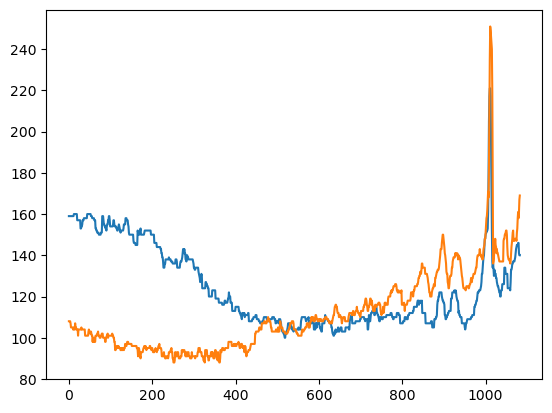

In [25]:
plt.plot(frames[0][80, :-217,  0])
plt.plot(frames[50][80, 217:, 0])
plt.show()

In [26]:
frames[0].shape[0] - 217 / 50 * 50

1083.0

In [27]:
row80 = []
for fid, frame in enumerate(frames[:50]):
    left_crop = np.round(217 / 50 * fid).astype(int)
    row80.append(frame[80, left_crop: left_crop + 1083, 0])

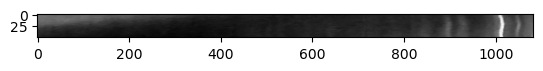

In [28]:
plt.imshow(np.array(row80), cmap="gray")
plt.show()

In [29]:
CENTER = 2025, 1150
RADIUS = 850
def mio_line(line_idx, shift, video_crop):
    xx = [x for x in np.arange(1300)] # if (x - CENTER[0]) ** 2 + (line_idx - CENTER[1]) ** 2 < RADIUS ** 2]
    x_int = slice(np.min(xx), np.max(xx))
    xx_len = np.max(xx) - np.min(xx)
    frame_count = video_crop[1] - video_crop[0]

    #lines = int(np.ceil(xx_len / np.abs(shift)) + 1)

    out = np.zeros((frame_count, int(np.ceil(np.abs(shift) * frame_count + xx_len))), dtype=float)
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, video_crop[0])
    if shift < 0:
        current_shift = out.shape[1] - xx_len
    else:
        current_shift = 0
    current_row = 0
    overlap = current_shift % 1
    for i in tqdm(np.arange(frame_count)):
        success, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)[line_idx, x_int]
        if not success:
            return
        gray_interpolated = np.interp(np.arange(overlap, xx_len), np.arange(xx_len), gray)
        if shift > 0:
            # first partial pixel
            out[current_row, int(np.floor(current_shift))] += (1 - overlap) * gray[0]
            # following full row
            out[current_row, int(np.ceil(current_shift)): int(np.ceil(current_shift)) + len(gray_interpolated)] = gray_interpolated
            # last partial pixel
            out[current_row, int(np.ceil(current_shift)) + len(gray_interpolated)] += gray[-1]
        else:
            # first partial pixel
            out[current_row, int(np.floor(current_shift)) + xx_len - 1] += overlap * gray[-1]
            # following full row
            out[current_row, int(np.ceil(current_shift)): int(np.ceil(current_shift) + len(gray_interpolated))] = gray_interpolated
            # last partial pixel
            out[current_row, int(np.floor(current_shift))] += gray[0]

        if current_row == 0:
            if shift < 0:
                line0_end = int(np.floor(current_shift) - len(gray_interpolated))
            else:
                line0_end = int(np.ceil(current_shift) + len(gray_interpolated))

        current_shift += shift
        # if (shift > 0 and np.floor(current_shift) >= line0_end) or (shift < 0 and np.ceil(current_shift) <= line0_end):
        #     current_row = 0
        # else:
        current_row += 1

    return out

In [30]:
speeds, frame.shape

({'horizontal': np.float64(3.722111439860243),
  'vertical_shift': np.float64(-867.0941905975342)},
 (1300, 1300, 3))

In [31]:
mioline = mio_line(80, -4, [25, 25*50])

  0%|          | 0/1225 [00:00<?, ?it/s]

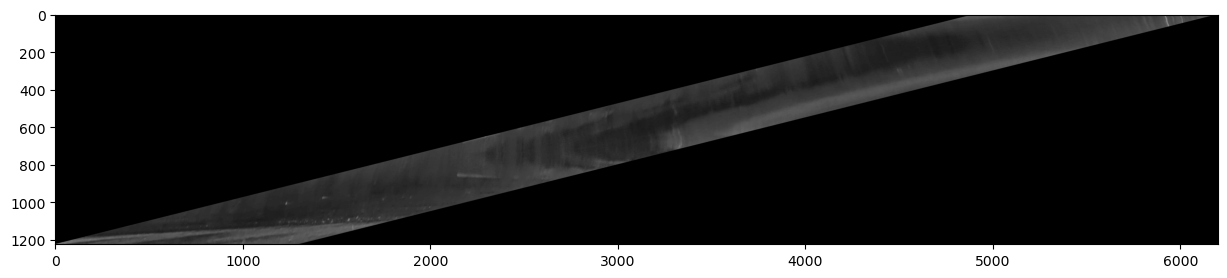

In [32]:
plt.figure(figsize=(15,5))
plt.imshow(mioline, cmap="gray")
plt.show()

In [35]:
iio.imwrite("~/mioline.png", mioline.astype(np.uint8))

In [348]:
np.sum(mioline != 0)

np.int64(5856)